In [98]:
import torch
import torch.nn as nn
import pandas
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Project 2

## igu011 and edj001

### Task 2.1

Load the 3 localization datasets localization XXX.pt. There is at most one digit per image.
All digits are represented (C = 10)

In [99]:
localization_train = torch.load("./data/localization_train.pt")
localization_test = torch.load("./data/localization_test.pt")
localization_val = torch.load("./data/localization_val.pt")

First let us take a look at the data and its labels

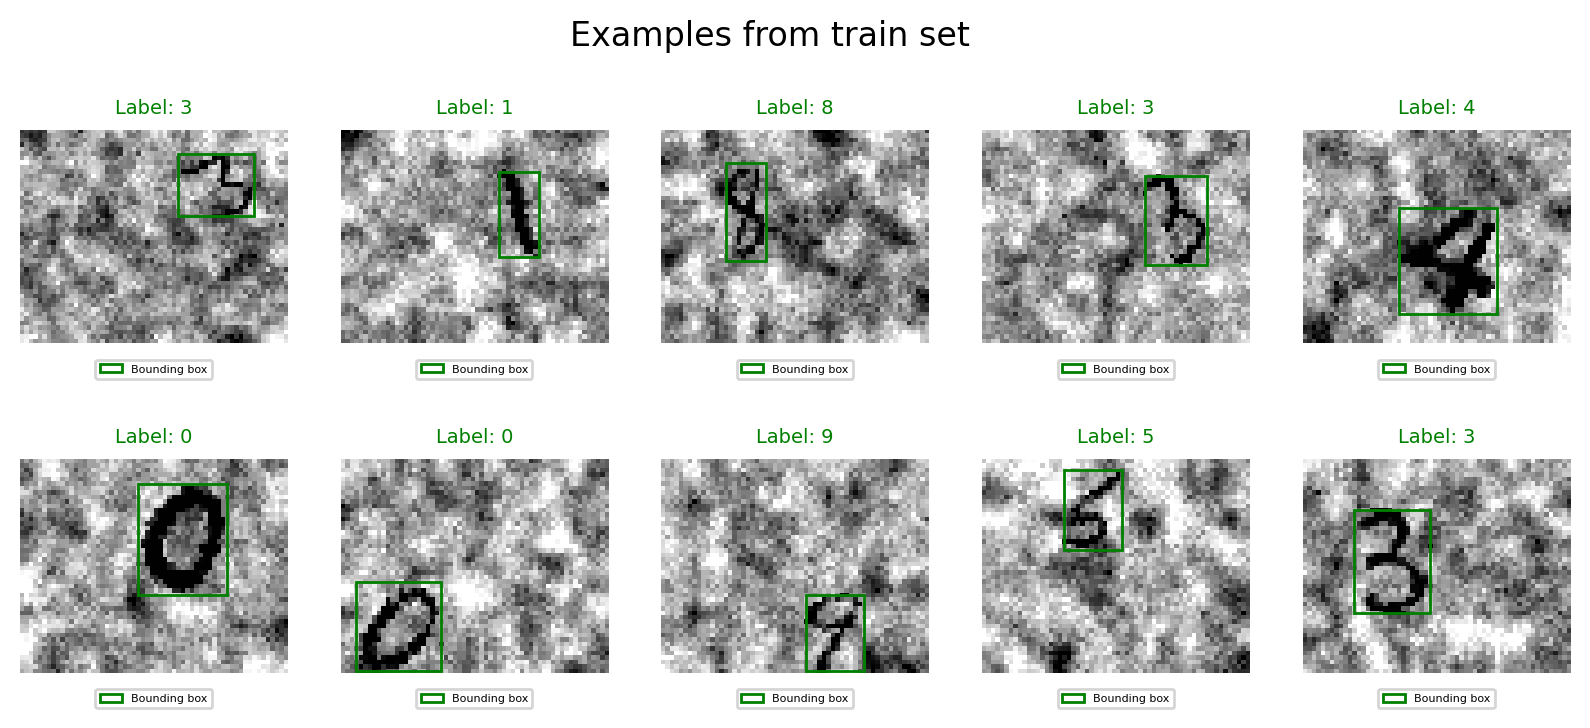

In [100]:
def to_lower_xy(input):
    scale_w = 60
    scale_h = 48
    x = input[1]*scale_w
    y = input[2]*scale_h
    w = input[3]*scale_w
    h = input[4]*scale_h

    lower_x = x - w/2
    lower_y = y - h/2

    return lower_x, lower_y, w, h


def plot_data(data, title):

    COL = 5
    ROW = 2
    fig = plt.figure(figsize=(10, 4), dpi=200)

    for index in range(1, COL * ROW + 1):
        plt.subplot(ROW, COL, index)
        plt.axis('off')
        plt.imshow(data.tensors[0][index][0], cmap='gray_r')
        plt.title(f"Label: {int(data.tensors[1][index][5])}", fontsize=7, color='green')
        x, y, w, h = to_lower_xy(data.tensors[1][index])
        rect = Rectangle((x, y), w, h, linewidth=1, edgecolor='g', facecolor='none')
        ax = plt.gca()
        ax.add_patch(rect)
        ax.legend(['Bounding box'], fontsize=4, loc='upper center', bbox_to_anchor=(0.5, -0.05),ncol=1)
    fig.suptitle(title);

plot_data(localization_train, "Examples from train set")

### Task 2.2

Implement and train several convolutional models suitable for an object localization task and
the data provided

In [101]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = nn.functional.softmax(logits, dim=1)
        return logits, probs

In [102]:
def train(n_epochs, optimizer, model, loss_fn, train_loader):
    n_batch = len(train_loader)
    losses_train = []
    model.train()
    optimizer.zero_grad(set_to_none=True)
    
    for epoch in range(1, n_epochs + 1):
        
        loss_train = 0.0
        for imgs, labels in train_loader:

            imgs = imgs.to(device=device, dtype=torch.double)
            labels = labels.to(device=device)

            outputs = model(imgs)
            
            loss = loss_fn(outputs, labels)
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()
            
        losses_train.append(loss_train / n_batch)

        if epoch == 1 or epoch % 10 == 0:
            print('{}  |  Epoch {}  |  Training loss {:.3f}'.format(
                datetime.now().time(), epoch, loss_train / n_batch))
    return losses_train

Loss function

In [103]:
BCE = nn.BCELoss()
sigmoid = nn.Sigmoid()
NLL = nn.NLLLoss()
MSE = nn.MSELoss()
logSoftmax = nn.LogSoftmax(dim = 1)


def loss_fn(Y_out, Y_true):
    
    L_detection = BCE(sigmoid(Y_out[:,0,:,:]), Y_true[:,0,:,:])
    
    TP_mask = (sigmoid(Y_out[:,0,:,:])>0.5) * (Y_true[:,0,:,:]==1)
    TP = torch.where(TP_mask)
    
    L_classification = 0.0
    L_regression = 0.0
    
    if len(TP[0]) > 0:
        L_classification = NLL(logSoftmax(Y_out[TP[0], 1:11, TP[1], TP[2]]), Y_true[TP[0], 1, TP[1], TP[2]].type(torch.long))
        L_regression = MSE(Y_out[TP[0], -4:, TP[1], TP[2]], Y_true[TP[0], -4:, TP[1], TP[2]])
    
    return L_detection + L_classification + L_regression